In [1]:
from dataloader import NetCDFSR, xr_standardize_field
import xarray as xr
import numpy as np
import glob
import torch

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from models import Generator, Discriminator

%load_ext autoreload
%autoreload 2

torch.cuda.empty_cache()

In [2]:
dataroot = "../data/era_interim/*.nc"
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

target = '10UV_GDS4_SFC'
uncropped = xr.open_mfdataset(glob.glob(dataroot), combine='by_coords')
uncropped[target] = xr.ufuncs.hypot(uncropped['10U_GDS4_SFC'], uncropped['10V_GDS4_SFC'])
xarr = uncropped[target][:30, ...]
xarr = xr_standardize_field(xarr)

In [3]:
assert np.abs(xr_standardize_field(xarr).mean()) < 10E-5
assert np.abs(xr_standardize_field(xarr).std() - 1.0) < 10E-5

In [4]:
midx = uncropped['10UV_GDS4_SFC'].values.shape[2] // 2
midy = uncropped['10UV_GDS4_SFC'].values.shape[1] // 2
assert midx >= 2*midy
midx, midy

(59, 28)

In [5]:
u10 = uncropped['10U_GDS4_SFC']
v10 = uncropped['10V_GDS4_SFC']
u10 = xr_standardize_field(u10)[:, :, midx-midy:midx+midy]
v10 = xr_standardize_field(v10)[:, :, midx-midy:midx+midy]

In [6]:
fine = uncropped['10UV_GDS4_SFC'][:, :, midx-midy:midx+midy]

In [7]:
sx, sy = 4, 4
coarse_u10 = u10.coarsen(g4_lon_2=sx).mean().coarsen(g4_lat_1=sy).mean()
coarse_v10 = v10.coarsen(g4_lon_2=sx).mean().coarsen(g4_lat_1=sy).mean()

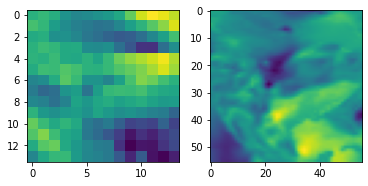

In [8]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse_u10[55, ...])
ax[1].imshow(v10[18, ...])

In [9]:
coarse = np.stack([coarse_u10, coarse_v10], axis=1)
fine = np.stack([u10, v10], axis=1)

In [10]:
fine.shape

(7308, 2, 56, 56)

In [11]:
# PCA
ncomp = 250
fine_pca_u10 = np.array(u10).reshape(u10.shape[0], u10.shape[1]*u10.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca_u10)
fine_sp_basis_u10 = pca.components_.reshape(ncomp, u10.shape[1]*u10.shape[2])

fine_pca_v10 = np.array(v10).reshape(v10.shape[0], v10.shape[1]*v10.shape[2])
pca = PCA(n_components=ncomp)
pca.fit(fine_pca_v10)
fine_sp_basis_v10 = pca.components_.reshape(ncomp, v10.shape[1]*v10.shape[2])

fine_sp_basis = np.stack([fine_sp_basis_u10, fine_sp_basis_v10], axis=1)

In [12]:
fine_t = torch.from_numpy(np.array(fine))
coarse_t = torch.from_numpy(np.array(coarse))
pcas_t = torch.from_numpy(fine_sp_basis)

In [13]:
dataset = NetCDFSR(
    fine_t,
    coarse_t,
    pcas_t,
    device=device
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

In [14]:
real_batch, real_cbatch, pcas = next(iter(dataloader))
fixed = {"coarse": real_cbatch[:1, ...], "fine": real_batch[:1, ...]}
pcas.size()
fixed["coarse"].shape

torch.Size([1, 2, 14, 14])

In [15]:
# pcas[:1, ...].size(), pcas[:1, ...].transpose(2, 1).size()
# X = pcas[0, ...]#pcas[:1, ...]#.transpose(2, 1)
# # torch.matmul(real, X).size()
# # X.unsqueeze(0).transpose(2, 1).size(), real.unsqueeze(2).transpose(2, 1).size()#transpose(-1, -2).unsqueeze(1).size()
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# A = real.unsqueeze(2).unsqueeze(1)#.transpose(-1, -2)
# B = X.unsqueeze(-1)#.transpose(3, 2)#.transpose(-1, -2)
# print(A.size())
# print(B.size())
# proj_real = torch.matmul(A, B)
# proj_fake = torch.matmul(A, B)

# coefficient_loss = torch.nn.L1Loss().to(device)
# coefficient_loss(proj_real, proj_fake).item()

In [16]:
# # real_batch.size(), pcas[:1, :, :1, :].size()
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )[:, :1, :]
# real.size()
# torch.matmul(real, X.transpose(3, 2))#.transpose(0, 1)

In [17]:
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# fake = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# projected_real = torch.matmul(real, pcas.transpose(2, 1)).transpose(0, 1)
# projected_fake = torch.matmul(fake, pcas.transpose(2, 1)).transpose(0, 1)

# projected_real.size()

# closs = coefficient_loss(projected_fake, projected_real).item()

In [18]:
# real = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# fake = torch.reshape(
#     real_batch, 
#     (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3))
# )

# projected_real = torch.matmul(real, pcas[:1, ...].transpose(3, 2)).transpose(0, 1)
# projected_fake = torch.matmul(fake, pcas[:1, ...].transpose(3, 2)).transpose(0, 1)

# projected_real.size()
# (projected_fake/torch.flip(torch.arange(1, projected_real.size(-1)+1), (0, ))).size()

In [19]:
from models import Generator, Discriminator, patch_discriminator

# discriminator = patch_discriminator().to(device)#Discriminator(7, 14, 1).to(device)
discriminator = Discriminator(7, 14, 2).to(device)
generator = Generator(14, 56, 2).to(device)
lr = 0.00025

In [ ]:
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(.9, .99))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(.9, .99))

# Set up trainer
from training import Trainer
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available(), print_every=500, save_every=500, device=device)

# Train model for 200 epochs
trainer.train(
    dataloader,
    epochs=600,
    fixed=fixed,
    save_training_gif=True
)


Epoch 1
Iteration 1
D: 9.999306678771973
GP: 9.999293327331543
Gradient norm: 3.53055729647167e-05
cuda memory: 420805632

Epoch 2
Iteration 1
D: 2.3830933570861816
GP: 2.3332676887512207
Gradient norm: 0.6450663805007935
cuda memory: 422404096
G: 0.5700348615646362
Content loss: 0.46920859813690186
EOF:  1.1658358573913574

Epoch 3
Iteration 1
D: 1.1402266025543213
GP: 0.8601048588752747
Gradient norm: 0.7817413806915283
cuda memory: 422404096
G: 0.41255590319633484
Content loss: 0.3294254243373871
EOF:  0.9884623885154724

Epoch 4
Iteration 1
D: 1.9499773979187012
GP: 1.4472782611846924
Gradient norm: 0.709895133972168
cuda memory: 422404096
G: 0.34667667746543884
Content loss: 0.2741760015487671
EOF:  0.8832667469978333

Epoch 5
Iteration 1
D: 2.805832624435425
GP: 2.2398934364318848
Gradient norm: 0.5870867371559143
cuda memory: 422404096
G: 0.324990451335907
Content loss: 0.25569620728492737
EOF:  0.8533815145492554

Epoch 6
Iteration 1
D: 0.4735063314437866
GP: 0.429533094167709